# Exploratory data analysis - FICO
### Kacper Siemaszko, Wojciech Kretowicz, Mateusz Polakowski
---

## Wgranie potrzebnych pakietów

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [25,17]

## Przygotowanie danych

In [3]:
df = pd.read_csv("data/heloc_dataset_v1.csv")

W zbiorze danych występują 3 klasy specjalnych wartości zmiennych oznaczonych przez:
* -9: *No Bureau Record or No Investigation*,
* -8: *No Usable/Valid Trades or Inquiries*,
* -7: *Condition not Met (e.g. No Inquiries, No Delinquencies)*.
<br/>

Ponieważ wartości -9, jeśli występowały, to w większości występowały we wszystkich kolumnach rekordu:

In [4]:
print("Same -9:", ((df == -9).sum(axis=1) == 23).sum())
print("Nie same -9:", ((df == -9).sum(axis=1) >0).sum())

Same -9: 588
Nie same -9: 598


to obserwacje zawierające -9 zostały wyrzucone. Pozostałe wartości specjalne występowały w niewielu kolumnach:

In [5]:
df = df.loc[(df == -9).sum(axis=1)==0, :]
print("Same -8:", ((df == -8).sum(axis=1) == 23).sum())
print("Nie same -8:", ((df == -8).sum(axis=1) >0).sum(), "\n")
print("Same -7:", ((df == -7).sum(axis=1) == 23).sum())
print("Nie same -7:", ((df == -7).sum(axis=1) >0).sum(), "\n")
print("Liczba rekordów w kolumnie z wartościami -7 lub -8:", ((df == -7) | (df == -8)).sum().sort_values(ascending=False), sep="\n")

# print(((X == -8).sum(axis=0) > 0)) # wersja rozszerzona dla wartosci -8
# print(((X == -7).sum(axis=0) > 0)) # wersja rozszerzona dla wartosci -7

Same -8: 0
Nie same -8: 4219 

Same -7: 0
Nie same -7: 5681 

Liczba rekordów w kolumnie z wartościami -7 lub -8:
MSinceMostRecentDelq                  4834
NetFractionInstallBurden              3412
MSinceMostRecentInqexcl7days          2329
NumInstallTradesWBalance               854
NumBank2NatlTradesWHighUtilization     576
MSinceOldestTradeOpen                  239
NetFractionRevolvingBurden             179
NumRevolvingTradesWBalance             149
PercentTradesWBalance                   11
NumTrades90Ever2DerogPubRec              0
ExternalRiskEstimate                     0
MSinceMostRecentTradeOpen                0
AverageMInFile                           0
NumSatisfactoryTrades                    0
NumTrades60Ever2DerogPubRec              0
MaxDelqEver                              0
PercentTradesNeverDelq                   0
MaxDelq2PublicRecLast12M                 0
NumTotalTrades                           0
NumTradesOpeninLast12M                   0
PercentInstallTrades      

zatem zostały one przetłumaczone na osobne kolumny binarne w nadziei, że taki zabieg pomoże przyszłym modelom w zadaniu klasyfikacji:

In [28]:
df = df.reset_index(drop=True)
df.loc[:,'is_MSinceMostRecentDelq_minus_7'] = df.MSinceMostRecentDelq == -7
df.loc[:,'is_MSinceMostRecentInqexcl7days_minus_7'] = df.MSinceMostRecentInqexcl7days == -7
df.loc[:,'is_MSinceOldestTradeOpen_minus_8'] = df.MSinceOldestTradeOpen == -8
df.loc[:,'is_MSinceMostRecentDelq_minus_8'] = df.MSinceMostRecentDelq == -8
df.loc[:,'is_MSinceMostRecentInqexcl7days_minus_8'] = df.MSinceMostRecentInqexcl7days == -8
df.loc[:,'is_NetFractionRevolvingBurden_minus_8'] = df.NetFractionRevolvingBurden == -8
df.loc[:,'is_NetFractionInstallBurden_minus_8'] = df.NetFractionInstallBurden == -8
df.loc[:,'is_NumRevolvingTradesWBalance_minus_8'] = df.NumRevolvingTradesWBalance == -8
df.loc[:,'is_NumInstallTradesWBalance_minus_8'] = df.NumInstallTradesWBalance == -8
df.loc[:,'is_NumBank2NatlTradesWHighUtilization_minus_8'] = df.NumBank2NatlTradesWHighUtilization == -8
df.loc[:,'is_PercentTradesWBalance_minus_8'] = df.PercentTradesWBalance == -8

Pogląd finalnej tabeli, której zamierzamy się zająć:

In [7]:
df.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,is_MSinceMostRecentInqexcl7days_minus_7,is_MSinceOldestTradeOpen_minus_8,is_MSinceMostRecentDelq_minus_8,is_MSinceMostRecentInqexcl7days_minus_8,is_NetFractionRevolvingBurden_minus_8,is_NetFractionInstallBurden_minus_8,is_NumRevolvingTradesWBalance_minus_8,is_NumInstallTradesWBalance_minus_8,is_NumBank2NatlTradesWHighUtilization_minus_8,is_PercentTradesWBalance_minus_8
0,Bad,55,144,4,84,20,3,0,83,2,...,False,False,False,False,False,True,False,False,False,False
1,Bad,61,58,15,41,2,4,4,100,-7,...,False,False,False,False,False,True,False,True,True,False
2,Bad,67,66,5,24,9,0,0,100,-7,...,False,False,False,False,False,False,False,False,False,False
3,Bad,66,169,1,73,28,1,1,93,76,...,False,False,False,False,False,False,False,False,False,False
4,Bad,81,333,27,132,12,0,0,100,-7,...,False,False,False,False,False,False,False,False,False,False


---
# Analiza danych
### Wartości -7, -8, -9

Na początku zauważmy, że jak wartości -9 w tabeli nie miały większego znaczenia, tak już -7 i -8 w niektórych kolumnach są mocno skorelowane z ostatecznym wynikiem scoringu:

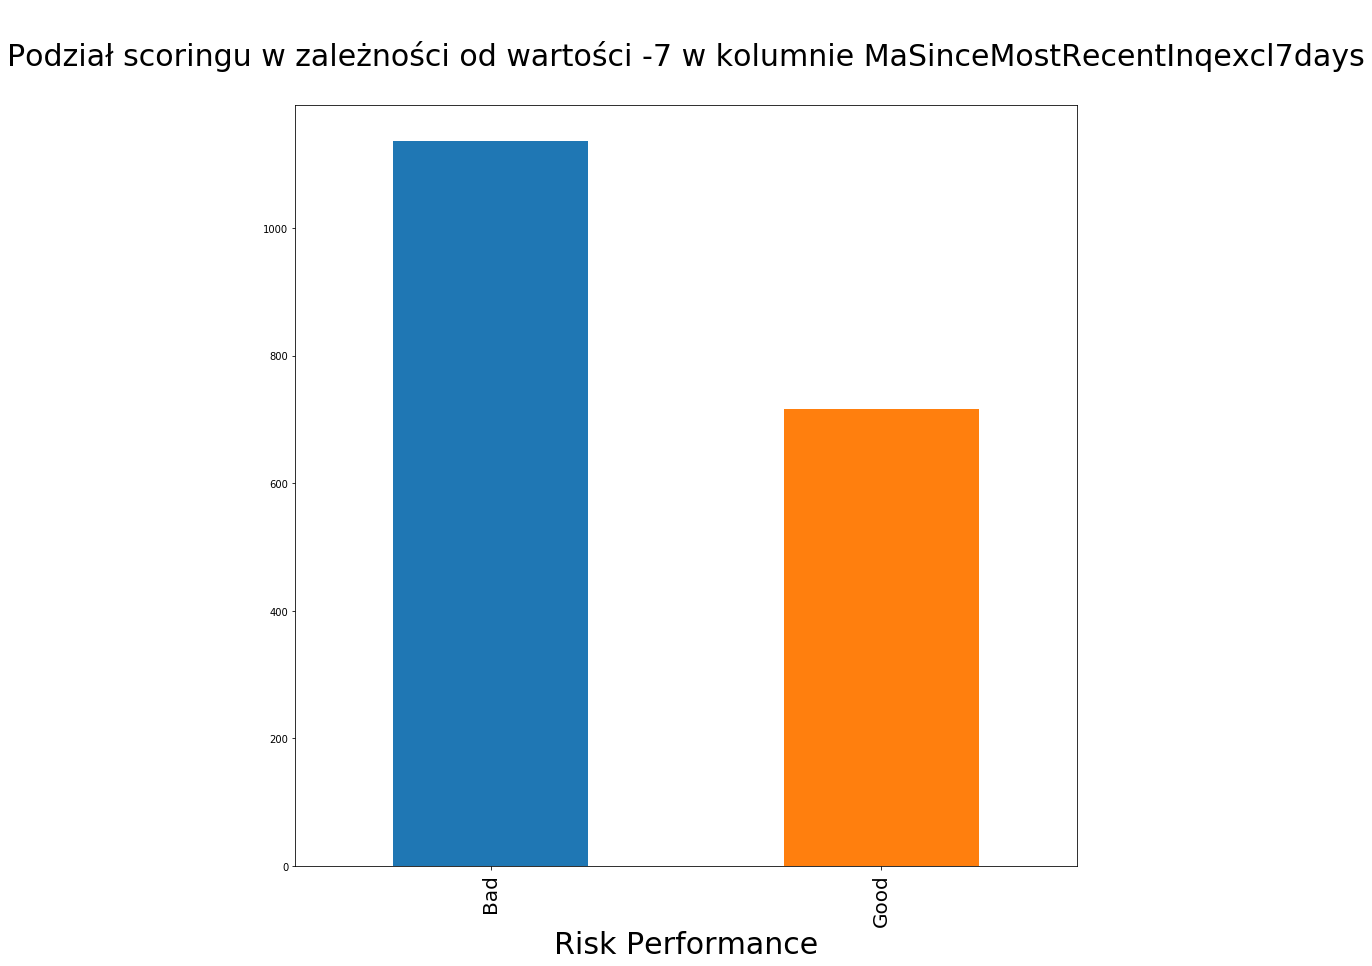

In [8]:
plt.figure(figsize=(14,14))
df.loc[(df.MSinceMostRecentInqexcl7days == -7), :
      ].groupby(by='RiskPerformance').count()['ExternalRiskEstimate'].plot(kind='bar')
plt.xlabel("Risk Performance", fontsize=30)
plt.xticks(fontsize=20)
plt.title("\nPodział scoringu w zależności od wartości -7 w kolumnie MaSinceMostRecentInqexcl7days\n", 
         fontsize=30)
plt.show()

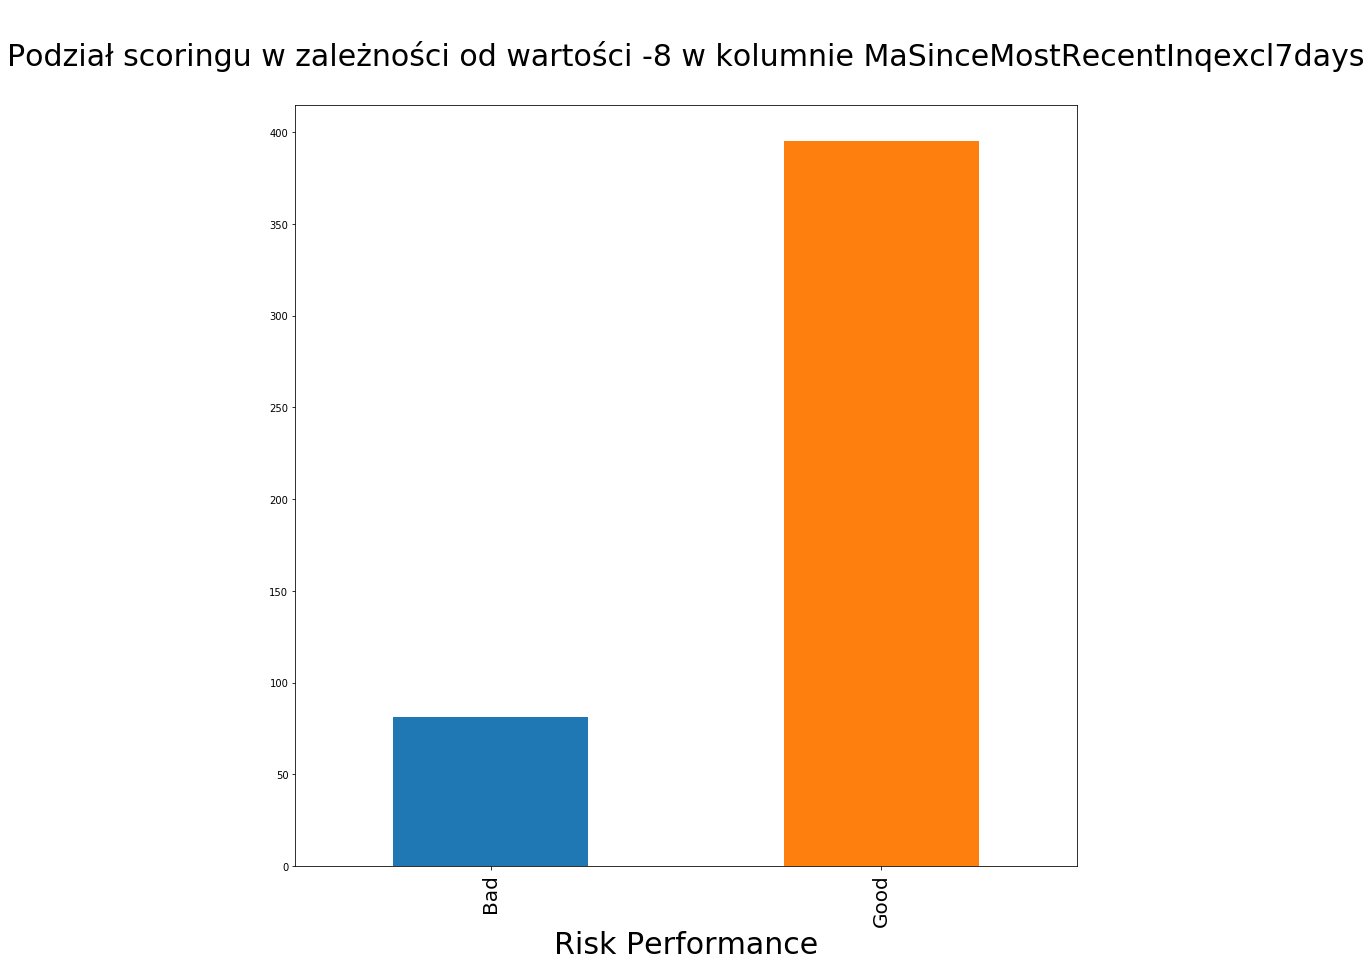

In [9]:
plt.figure(figsize=(14,14))
df.loc[(df.MSinceMostRecentInqexcl7days == -8), :
      ].groupby(by='RiskPerformance').count()['ExternalRiskEstimate'].plot(kind='bar')
plt.xlabel("Risk Performance", fontsize=30)
plt.xticks(fontsize=20)
plt.title("\nPodział scoringu w zależności od wartości -8 w kolumnie MaSinceMostRecentInqexcl7days\n", 
         fontsize=30)
plt.show()

### Rozkłady zmiennych
Zobaczmy ponadto jaki rozkład mają poszczególne cechy w tabeli

0: ExternalRiskEstimate
1: MSinceOldestTradeOpen
2: MSinceMostRecentTradeOpen
3: AverageMInFile
4: NumSatisfactoryTrades
5: NumTrades60Ever2DerogPubRec
6: NumTrades90Ever2DerogPubRec
7: PercentTradesNeverDelq
8: MSinceMostRecentDelq
9: MaxDelq2PublicRecLast12M
10: MaxDelqEver
11: NumTotalTrades
12: NumTradesOpeninLast12M
13: PercentInstallTrades
14: MSinceMostRecentInqexcl7days
15: NumInqLast6M
16: NumInqLast6Mexcl7days
17: NetFractionRevolvingBurden
18: NetFractionInstallBurden
19: NumRevolvingTradesWBalance
20: NumInstallTradesWBalance
21: NumBank2NatlTradesWHighUtilization
22: PercentTradesWBalance


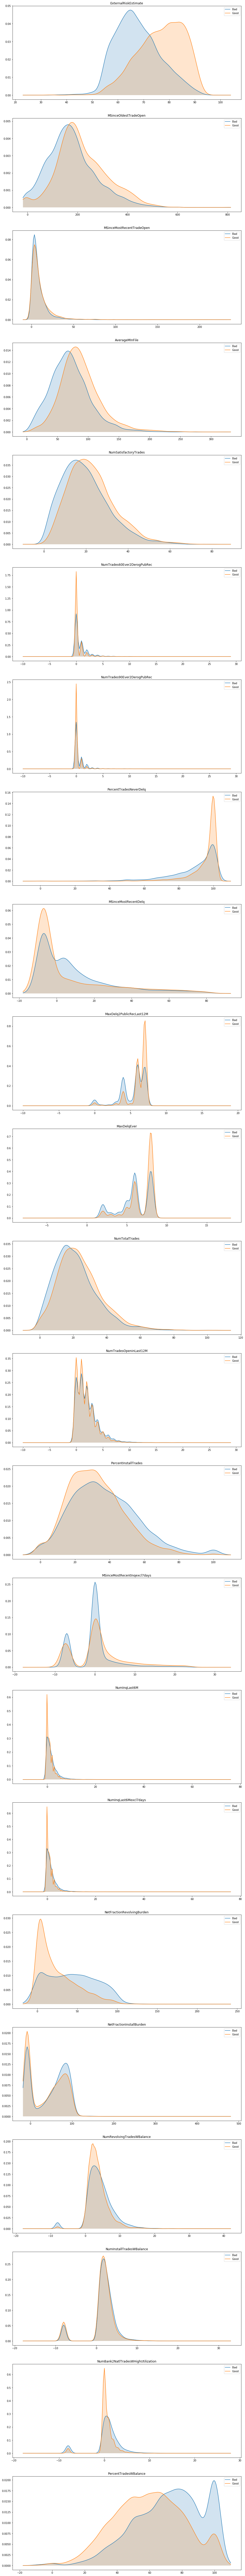

In [21]:
n_rows = len(df.columns[1:24])
fig = plt.figure(figsize=(16,n_rows*8))
axes = fig.subplots(nrows=n_rows, ncols=1)
for i, column in enumerate(df.columns[1:24]):
    if(column == 'RiskPerformance'):
        continue
    bad = df.loc[df.RiskPerformance=="Bad", column].astype('float')
    bad_density = stats.kde.gaussian_kde(bad)
    good = df.loc[df.RiskPerformance=="Good", column].astype('float')
    good_density = stats.kde.gaussian_kde(good)
    x=np.linspace(min(np.min(good), np.min(bad))-10, max(np.max(good), np.max(bad))+10, 200)
    print(f'{i}: {column}')
    axes[i].plot(x, bad_density(x), label="Bad")
    axes[i].fill_between(x, bad_density(x), alpha=0.2)
    axes[i].plot(x, good_density(x), label="Good")
    axes[i].fill_between(x, good_density(x), alpha=0.2)
    axes[i].legend()
    axes[i].set_title(column)
plt.show()

In [ ]:
print(YEARMONTH.groupby('CLIENTCODE').size())

RiskPerformance  is_PercentTradesWBalance_minus_8
Bad              False                               5120
                 True                                   8
Good             False                               4730
                 True                                   3
dtype: int64

0: is_MSinceMostRecentDelq_minus_7
1: is_MSinceMostRecentInqexcl7days_minus_7
2: is_MSinceOldestTradeOpen_minus_8
3: is_MSinceMostRecentDelq_minus_8
4: is_MSinceMostRecentInqexcl7days_minus_8
5: is_NetFractionRevolvingBurden_minus_8
6: is_NetFractionInstallBurden_minus_8
7: is_NumRevolvingTradesWBalance_minus_8
8: is_NumInstallTradesWBalance_minus_8
9: is_NumBank2NatlTradesWHighUtilization_minus_8
10: is_PercentTradesWBalance_minus_8


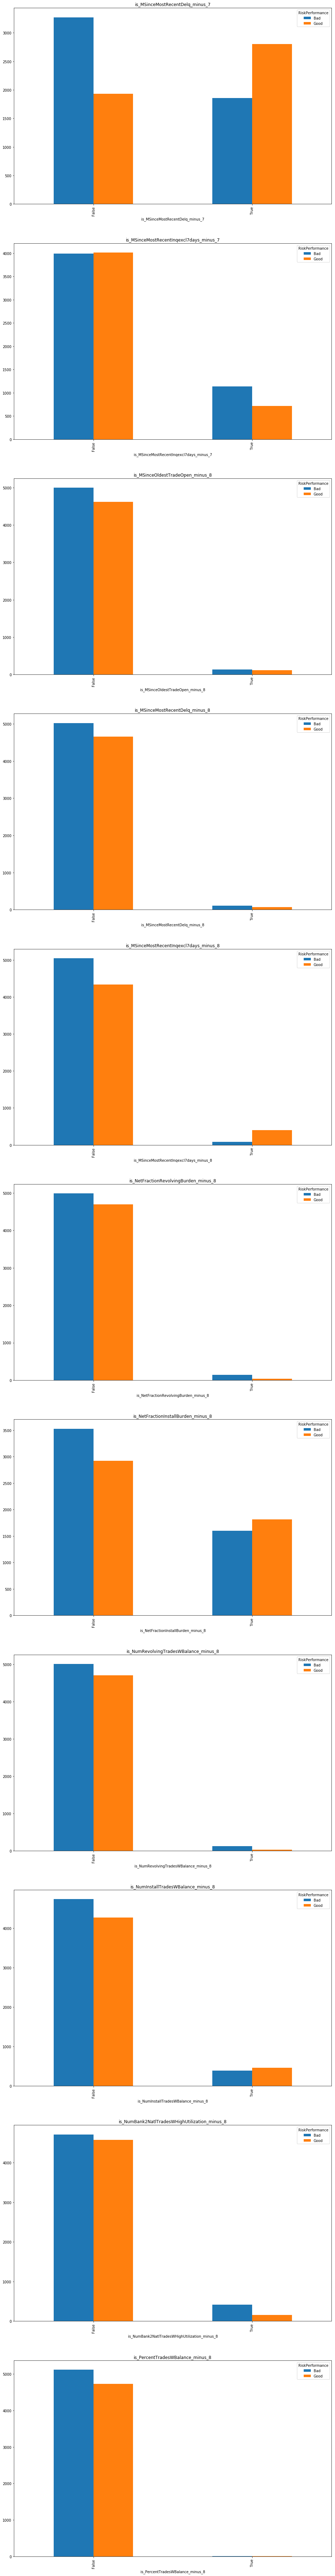

In [49]:
n_rows = len(df.columns[24:])
fig = plt.figure(figsize=(16,n_rows*12))
axes = fig.subplots(nrows=n_rows, ncols=1)
for i, column in enumerate(df.columns[24:]):
    if(column == 'RiskPerformance'):
        continue
    print(f'{i}: {column}')
    df.loc[:,["RiskPerformance",column]].groupby(by=[column,"RiskPerformance"]).size().unstack().plot(kind="bar", ax=axes[i])
    axes[i].set_title(column)
plt.show()

### Wykresy skrzynkowe (wystandaryzowane)
Aby przeanalizować dokładnie dystrybucje wartości zmiennych warto spojrzeć na ich wykresy skrzynkowe. Przed tym jednak warto kolumny wystandaryzować, wszystko było czytelniejsze.

In [55]:
X, y = df.drop('RiskPerformance', axis=1), df.RiskPerformance

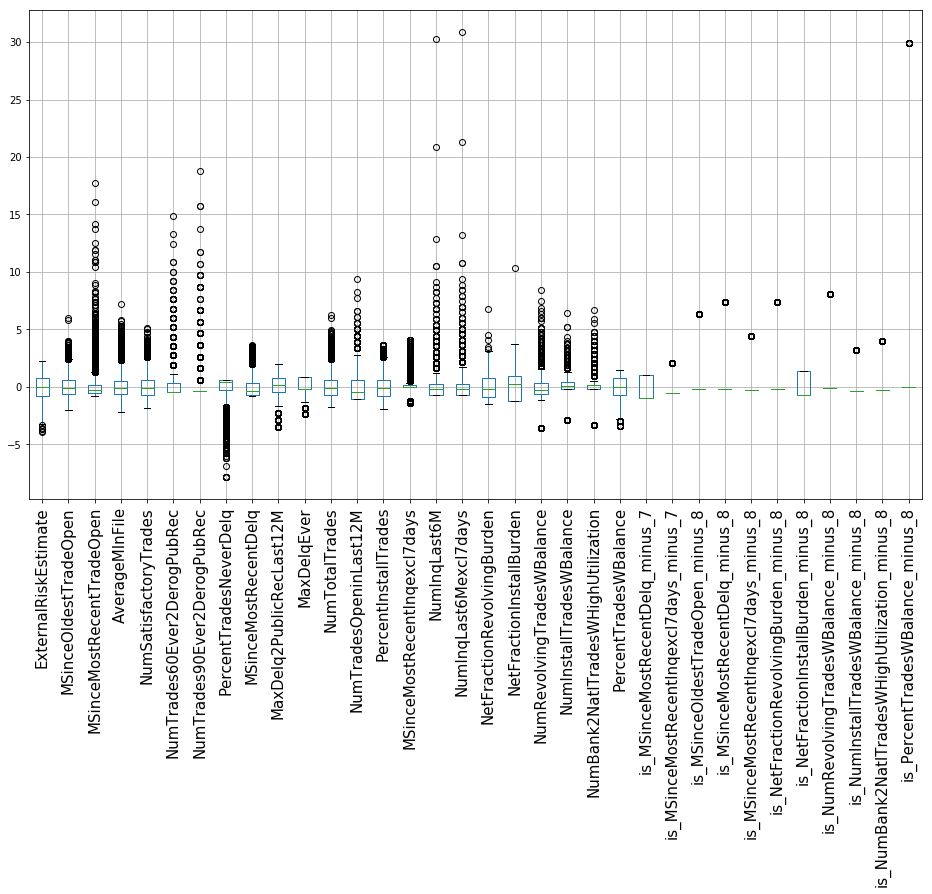

In [56]:
stdsc = StandardScaler()
X_std = stdsc.fit_transform(X)
df_std = pd.DataFrame(X_std, columns=X.columns)
plt.figure(figsize=(16,9))
df_std.boxplot()
plt.xticks(rotation=90, fontsize=15)
plt.show()

### Korelacja między zmiennymi

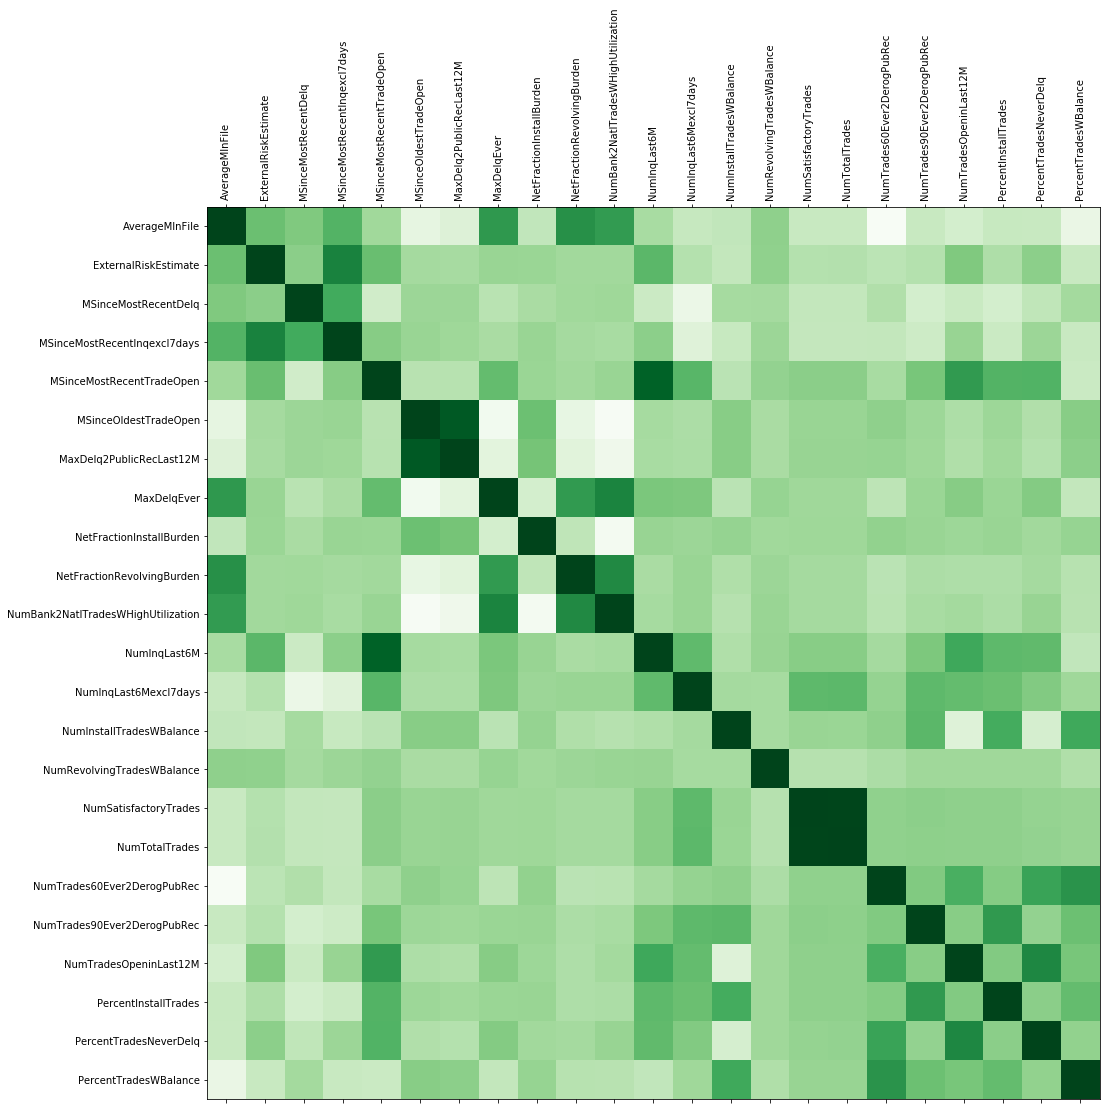

In [82]:
plt.matshow(df.iloc[:, 1:24].corr(), cmap=plt.cm.Greens, )
plt.xticks(np.arange(0, 23), df.columns.sort_values(), rotation=90)
plt.yticks(np.arange(0, 23), df.columns.sort_values())
plt.show()

Można zauważyć w niektórych miejscach silniejszą korelację miedzy kolumnami, na przykład *NumSatisfactoryTrades* a *NumTotalTrades* (stwierdzić to można po coraz ciemniejszych odcieniach zieleni na powyższym wykresie). Idąc dalej tropem korelacji dwóch wspomnianych kolumn, spójrzmy na wykres punktowy tych zmiennych i przekonajmy się, że faktycznie istnieje pewna korelacja między nimi: 

<Figure size 1152x1152 with 0 Axes>

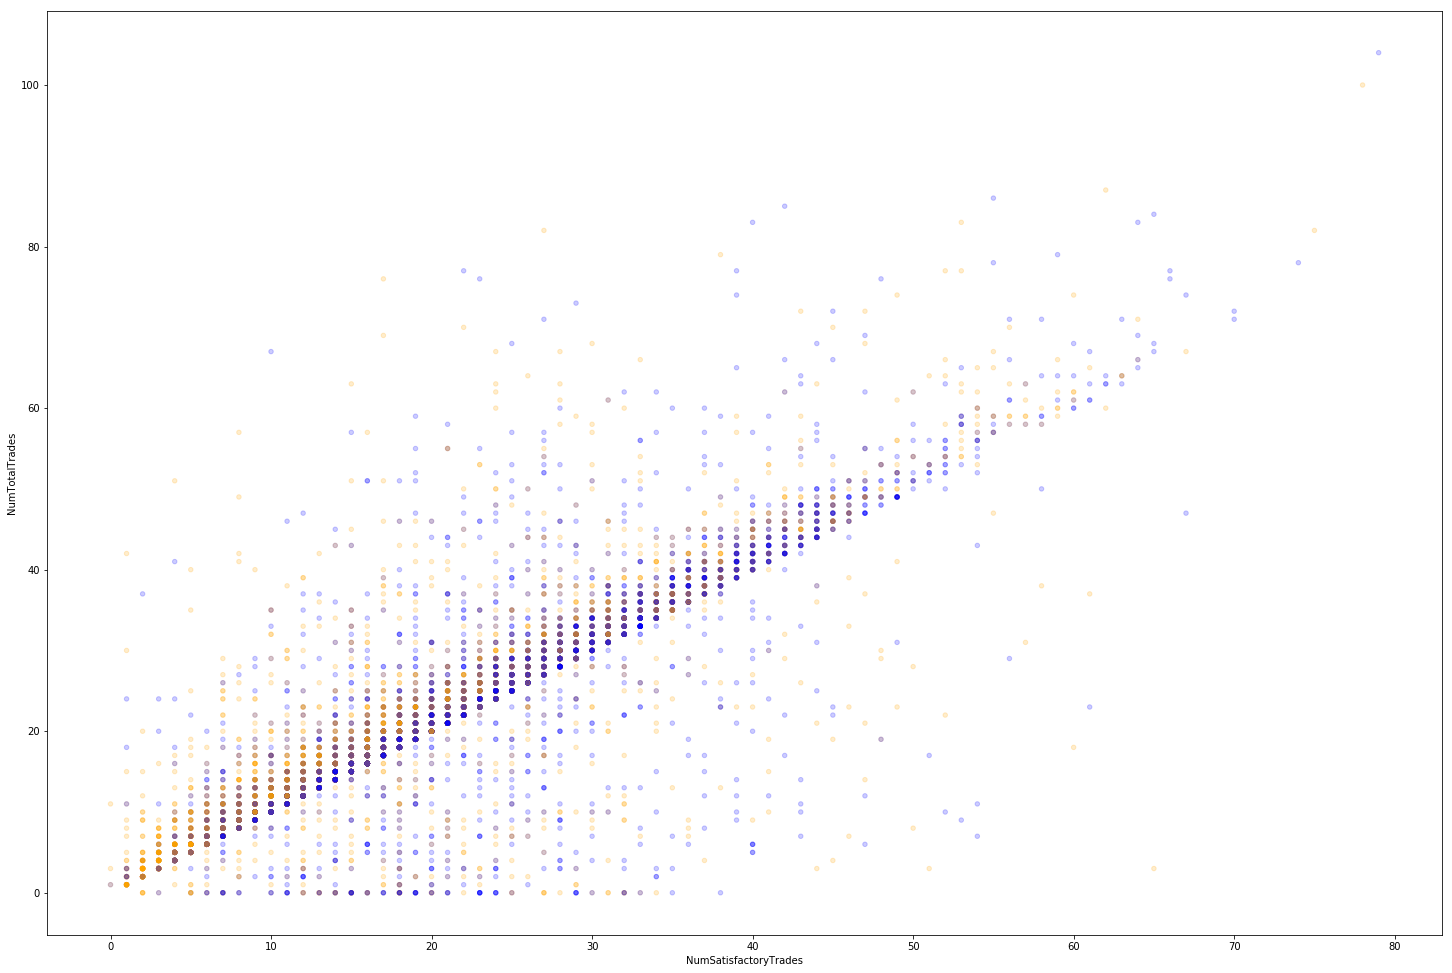

In [80]:
fig = plt.figure(figsize=(16,16))
c=(df.RiskPerformance=='Good').apply(lambda x : 'blue' if x==1 else 'orange')
df.plot(kind='scatter', x='NumSatisfactoryTrades', y='NumTotalTrades', c=c, alpha=0.2)
plt.show()

### Budowanie modeli
Chcąc zbadać znaczenie zmiennych w zbiorze danych zbudowaliśmy model predykcyjny oparty na algorytmie lasu losowego. Ucząc go przy okazji otrzymaliśmy ważną informację, która wskazuje na cechy posiadające największą wagę w całej tabeli.

In [62]:
y = pd.Categorical(y, categories=["Bad", "Good"]).codes

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=X.is_MSinceMostRecentDelq_minus_7)

classifier = RandomForestClassifier(n_estimators = 2000, max_depth=10, random_state=42)
classifier.fit(X_train, y_train)

print(f'Training set performance: {accuracy_score(y_train, classifier.predict(X_train))}')
print(f'Cross val set performance: {np.mean(cross_val_score(classifier, X_train, y_train, cv=5, scoring="accuracy"))}')

Training set performance: 0.8476315475480253
Cross val set performance: 0.7336823951678413


Jak widać na powyższych dwóch wartościach, model nie jest nadmiernie przeuczony, zatem jego lista cech z największym znaczeniem będzie tożsama z rzeczywistością: 

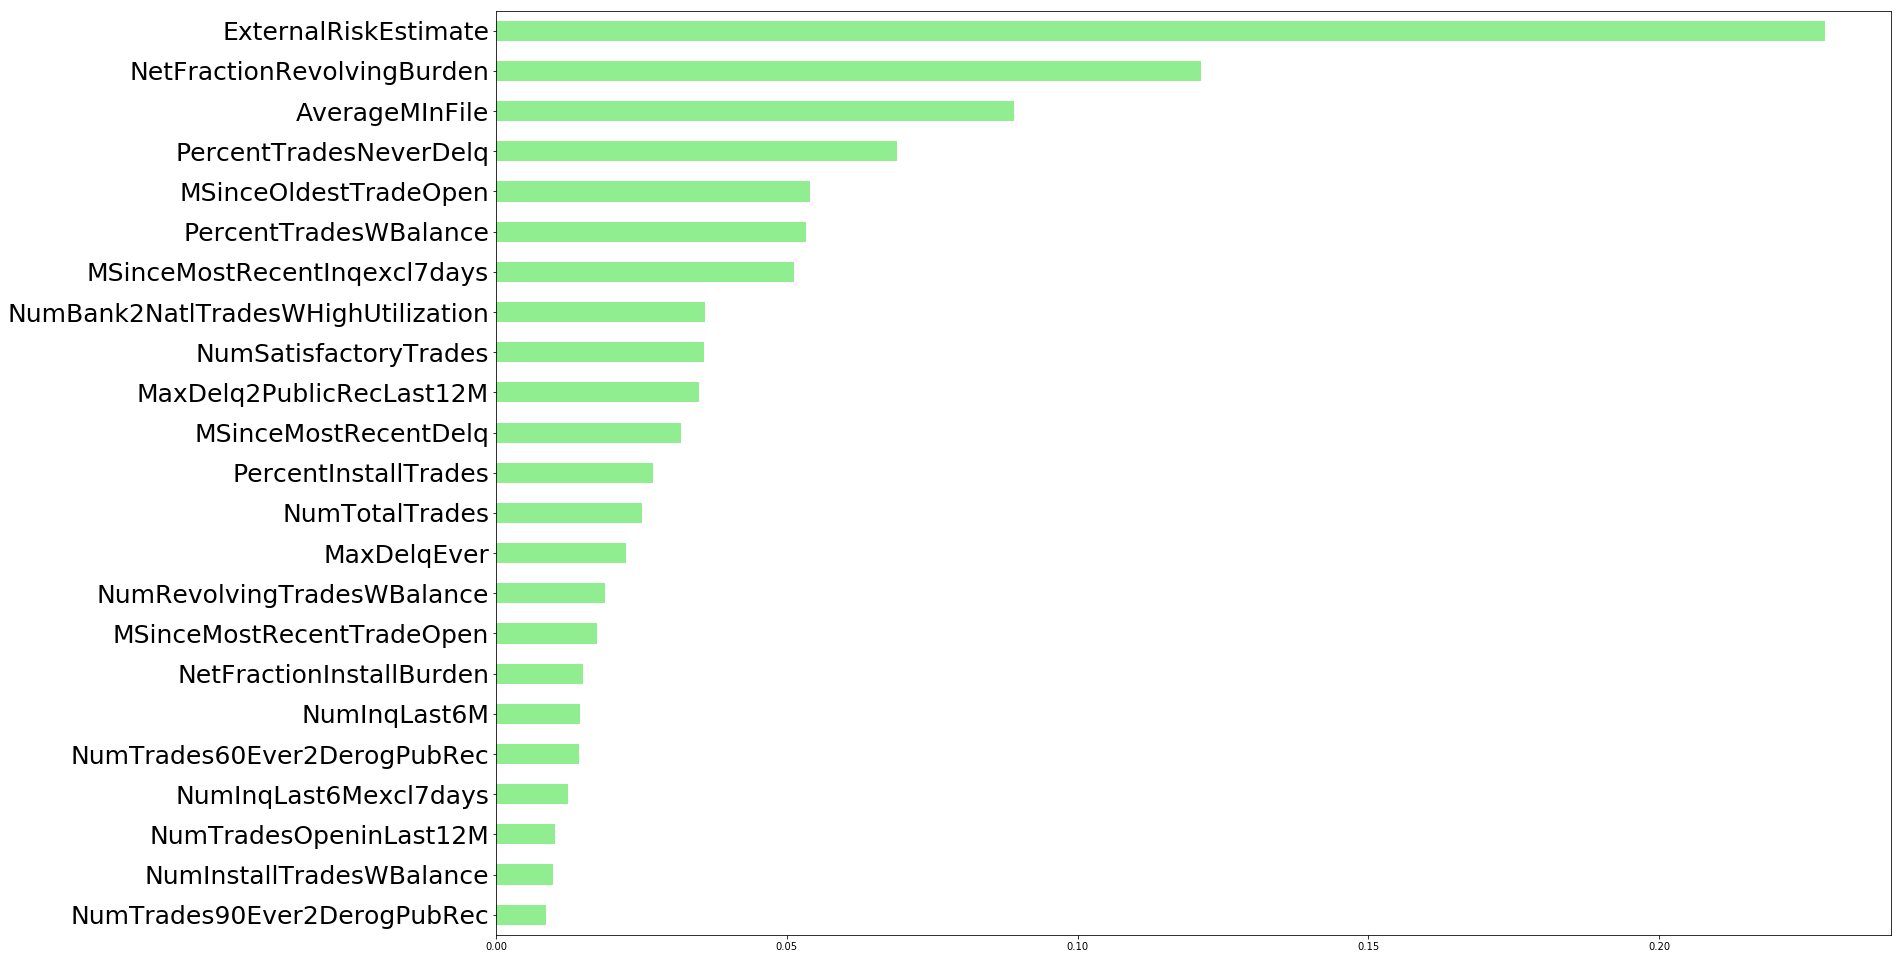

In [72]:
importances = pd.Series(dict(zip(X.columns,classifier.feature_importances_)))
importances.sort_values().plot(kind='barh', color='lightgreen')
plt.yticks(fontsize=25)
plt.show()

### Redukcja wymiarów
Zobaczmy jeszcze, czy zredukowanie wymiarów przy użyiu algorytmów takich jak *TSNE* lub *PCA* pomogą w odróżnieniu dwóch wyjściowych klas zbioru.

[]

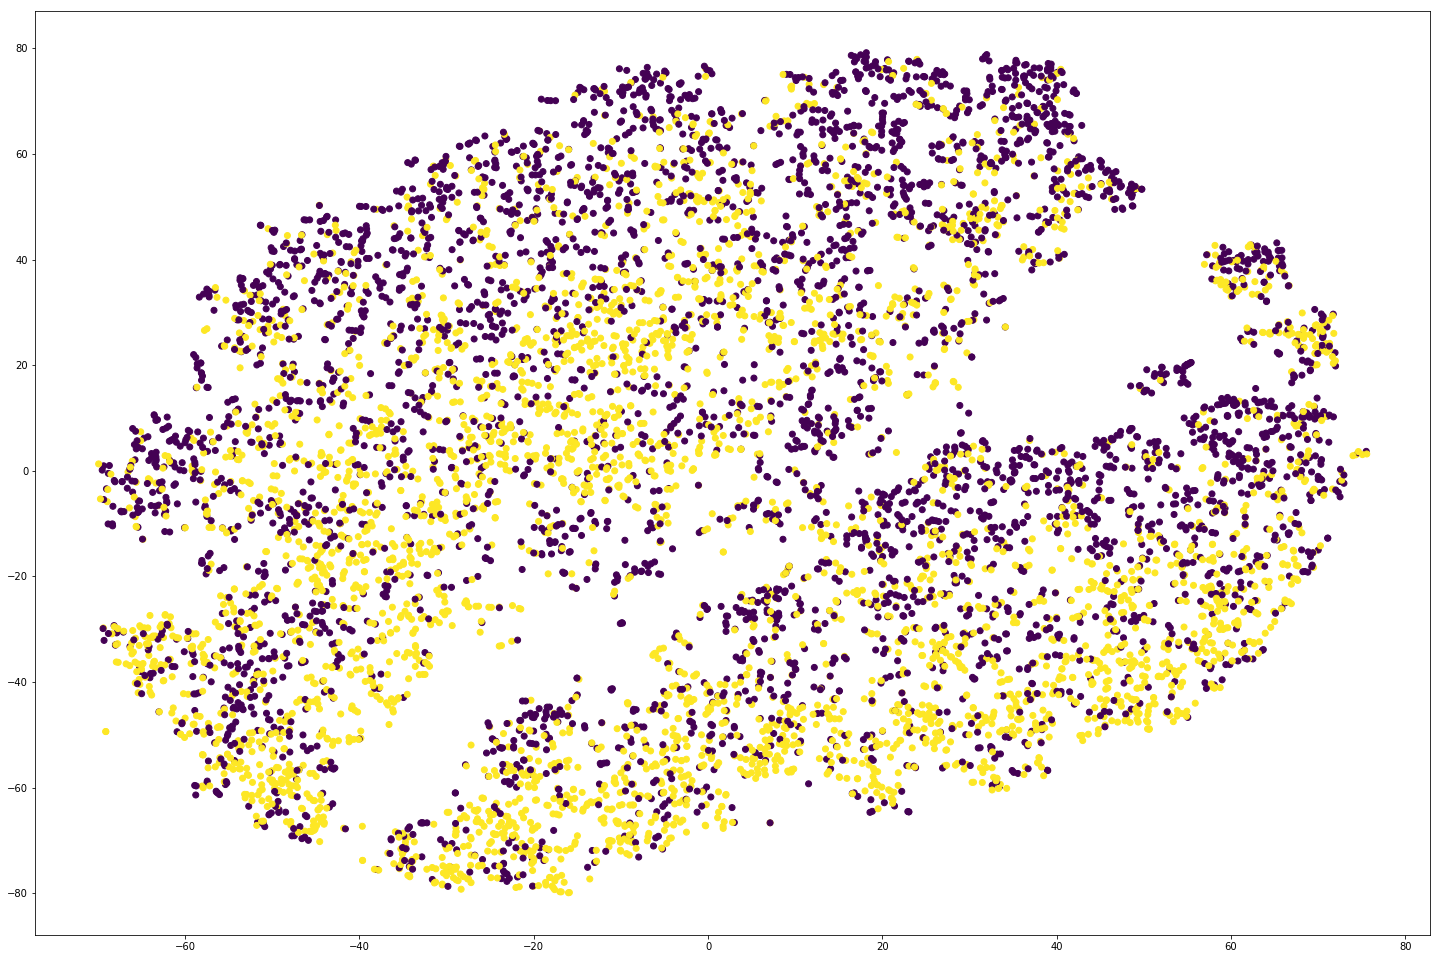

In [74]:
tsne = TSNE()
tsne.fit(X_train)
plt.scatter(tsne.embedding_[:, 0], tsne.embedding_[:, 1], c=y_train)
plt.plot()

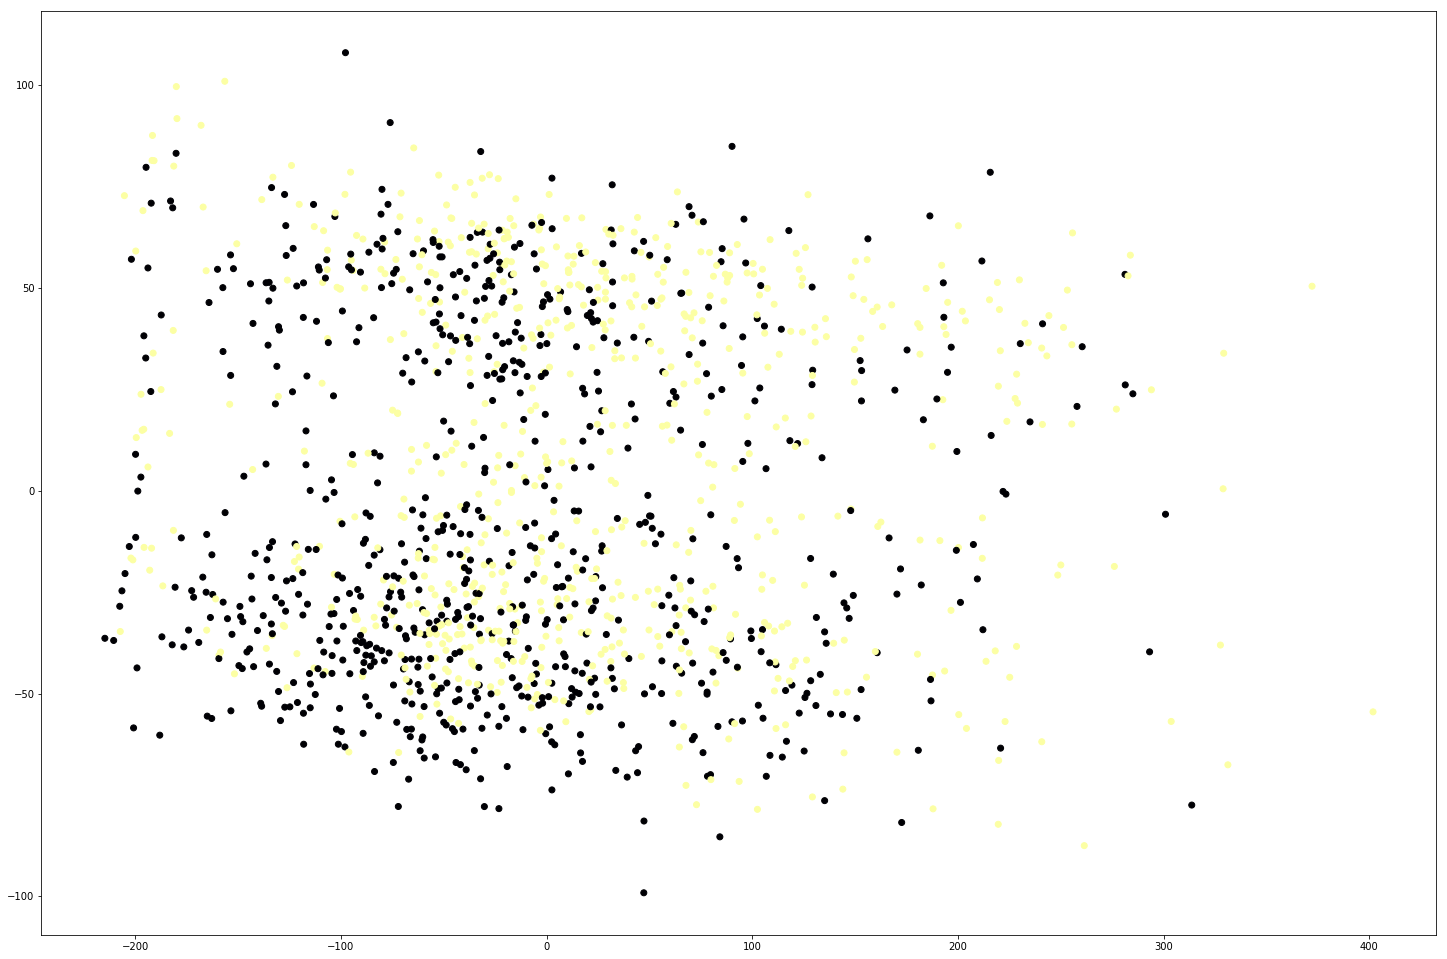

In [95]:
pca = PCA(n_components=2, svd_solver='full')
X_test_pca = pca.fit_transform(X_test)
plt.scatter(X_test_pca[:, 0],X_test_pca[:, 1], c=y_test, cmap='inferno')
plt.show()

In [99]:
stdsc = StandardScaler()
svc = SVC()
pipeline = make_pipeline(stdsc, svc)
pipeline.fit(X_train, y_train)
np.mean(pipeline.predict(X_test) == y_test)

0.7351351351351352

In [248]:
a = pd.DataFrame(X_test, columns=X.columns).loc[classifier.predict(X_test)!=y_test]
print(a.shape)
print(((a == -8).sum(axis=1) >0).sum())
print(((a == -7).sum(axis=1) >0).sum())

(391, 34)


169


217


In [210]:
b = X_test.loc[pip.predict(X_test) != y_test, :]

print(b.shape)
print(((b == -8).sum(axis=1) >0).sum())
print(((b == -7).sum(axis=1) >0).sum())

/opt/anaconda/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


(395, 23)


166


214


In [215]:
len(set(a.index).intersection(set(b.index)))

353